In [1]:
%matplotlib notebook

from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pvlib

import cpvlib

In [2]:
lat, lon = 40.4, -3.7
tilt = lat - 10

diffuse_model = 'haydavies'

eff_opt_cpv = 0.83
eff_opt_pv = 0.70

spillage_factor = 0.02

In [3]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

In [4]:
A_ref = 10

# Soitec CX-M500

A = 7.386  # m2

corr = A_ref / A
A *= corr
cpv_mod_params = {
    "alpha_sc": 0.00,
    "gamma_ref": 3.664,
    "mu_gamma": 0.003,
    "I_L_ref": 3.861 *1.274*eff_opt_cpv *sqrt(corr),
    "I_o_ref": 0.005e-9,
    "R_sh_ref": 3461,
    "R_sh_0": 25000,
    "R_s": 0.61,
    "EgRef": 3.91,
    "cells_in_series": 240 *sqrt(corr),
    "irrad_ref":943,
    "temp_ref":64
}

UF_parameters_cpv = {
    "IscDNI_top": 1,
    "am_thld": 1.7,
    "am_uf_m_low": 0.1,
    "am_uf_m_high": -0.1,
    "ta_thld": 25,
    "ta_uf_m_low": 0.005,
    "ta_uf_m_high": 0,
    "weight_am": 0.55,
    "weight_temp": 0.45,
}

cpv_mod_params.update(UF_parameters_cpv)

cpv_temp_mod_params = {"eta_m": 0.32, "u_c":29.0, "u_v":0.6}

static_cpv_sys = cpvlib.StaticCPVSystem(
        surface_tilt=tilt,
        surface_azimuth=180,
        module_parameters=cpv_mod_params,
        temperature_model_parameters=cpv_temp_mod_params,
        modules_per_string=1,
)

cpv_irradiance = static_cpv_sys.get_irradiance(
    solpos['zenith'], solpos['azimuth'], data['dni'])

aoi = static_cpv_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)

theta_ref = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
iam_ref = [1.000, 1.007, 0.998, 0.991, 0.971, 0.966, 0.938, 0.894, 0.830, 0.790, 0.740, 0.649, 0.387]

cpv_effective_irradiance = cpv_irradiance * pvlib.iam.interp(aoi, theta_ref, iam_ref, method='linear')

#pd.Series(iam_ref, theta_ref).plot()

cpv_cell_temp = static_cpv_sys.pvsyst_celltemp(
    poa_global=cpv_effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

cpv_diode_parameters = static_cpv_sys.calcparams_pvsyst(
    effective_irradiance=cpv_effective_irradiance,
    temp_cell=cpv_cell_temp,
)

cpv_power_no_uf = static_cpv_sys.singlediode(*cpv_diode_parameters)

data['am'] = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_cpv_sys.get_am_util_factor(data['am'])

cpv_power_p_mp = cpv_power_no_uf['p_mp'] * uf_cpv

# calcula Pmp STC
cpv_Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticCPVSystem(
    module_parameters=cpv_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = cpv_Pdc_stc / (1000 * A)

print(f'Pdc_stc={cpv_Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=3487 eff_a=34.87%


C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:206: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [5]:
# FLATPLATE SOLO DIFUSA
A_ref = 10

# Canadian Solar CS1U-410MS - PVSyst
A = 2.061  # m2

corr = A_ref / A
A *= corr

pv_diffuse_mod_params = {
    "alpha_sc": 4.8e-3,  # coef. temp. Isc
    "gamma_ref": 0.967,  # "Datos básicos"
    "mu_gamma": -0.00042,  # "Parámetros modelo" [1/K]
    "I_L_ref": 9.7 *eff_opt_pv *sqrt(corr), # Isc
    "I_o_ref": 0.03e-9,  # "Datos básicos"
    "R_sh_ref": 600,  # R paral ref "Parámetros modelo"
    "R_sh_0": 2500,  # R paral G=0 W/m2 "Parámetros modelo"
    "R_s": 0.291,  # R serie "Parámetros modelo"
    "cells_in_series": 81 *sqrt(corr),
}

pv_diffuse_temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']

static_flatplate_sys = cpvlib.StaticFlatPlateSystem(
    surface_tilt=tilt,
    surface_azimuth=180,
    module_parameters=pv_diffuse_mod_params,
    temperature_model_parameters=pv_diffuse_temp_mod_params,
    modules_per_string=1,
)

#pv_diffuse_irradiance = pvlib.irradiance.get_total_irradiance(
#    static_flatplate_sys.surface_tilt, static_flatplate_sys.surface_azimuth,
#    solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
#    dni=data['dni'], ghi=data['ghi'], dhi=data['dhi']
#    dni_extra=pvlib.irradiance.get_extra_radiation(data.index), model=diffuse_model
#)['poa_diffuse']

aoi = static_flatplate_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)

irradiance_spillage = cpv_irradiance * spillage_factor

# pv_diffuse_effective_irradiance = (
#     pvlib.irradiance.beam_component(
#             surface_tilt=static_flatplate_sys.surface_tilt,
#             surface_azimuth=static_flatplate_sys.surface_azimuth,
#             solar_zenith=solpos['zenith'],
#             solar_azimuth=solpos['azimuth'],
#             dni=data['dni'])
# ) * pvlib.iam.martin_ruiz(aoi, a_r=0.16) + irradiance_spillage

pv_diffuse_effective_irradiance = (
    static_flatplate_sys.get_irradiance(
    solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
    aoi=aoi, aoi_limit=90, # limita por aoi siempre, solo ve difusa
    dni=data['dni'], ghi=data['ghi'], dhi=data['dhi'])
) * pvlib.iam.martin_ruiz(aoi, a_r=0.16) + irradiance_spillage

pv_diffuse_cell_temp = static_flatplate_sys.pvsyst_celltemp(
    poa_flatplate_static=pv_diffuse_effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

pv_diffuse_diode_parameters = static_flatplate_sys.calcparams_pvsyst(
    effective_irradiance=pv_diffuse_effective_irradiance,
    temp_cell=pv_diffuse_cell_temp,
)

pv_diffuse_power = static_flatplate_sys.singlediode(*pv_diffuse_diode_parameters)

# calcula Pmp STC
pv_diffuse_Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticFlatPlateSystem(
    module_parameters=pv_diffuse_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = pv_diffuse_Pdc_stc / (1000 * A)

print(f'Pdc_stc={pv_diffuse_Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=1433 eff_a=14.33%


C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:713: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


In [6]:
# FLATPLATE SOLO DNI
A_ref = 10

# Canadian Solar CS1U-410MS - PVSyst
A = 2.061  # m2

corr = A_ref / A
A *= corr

pv_dni_mod_params = {
    "alpha_sc": 4.8e-3,  # coef. temp. Isc
    "gamma_ref": 0.967,  # "Datos básicos"
    "mu_gamma": -0.00042,  # "Parámetros modelo" [1/K]
    "I_L_ref": 9.7 *eff_opt_pv *sqrt(corr), # Isc
    "I_o_ref": 0.03e-9,  # "Datos básicos"
    "R_sh_ref": 600,  # R paral ref "Parámetros modelo"
    "R_sh_0": 2500,  # R paral G=0 W/m2 "Parámetros modelo"
    "R_s": 0.291,  # R serie "Parámetros modelo"
    "cells_in_series": 81 *sqrt(corr),
}

pv_dni_temp_mod_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['pvsyst']['freestanding']

static_flatplate_sys = cpvlib.StaticFlatPlateSystem(
    surface_tilt=tilt,
    surface_azimuth=180,
    module_parameters=pv_dni_mod_params,
    temperature_model_parameters=pv_dni_temp_mod_params,
    modules_per_string=1,
)

#pv_dni_irradiance = pvlib.irradiance.get_total_irradiance(
#    static_flatplate_sys.surface_tilt, static_flatplate_sys.surface_azimuth,
#    solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
#    dni=data['dni'], ghi=data['ghi'], dhi=data['dhi']
#)['poa_diffuse']

aoi = static_flatplate_sys.get_aoi(
    solar_zenith=solpos['zenith'],
    solar_azimuth=solpos['azimuth'],
)

irradiance_spillage = cpv_irradiance * spillage_factor

pv_dni_effective_irradiance = (
    pvlib.irradiance.beam_component(
            surface_tilt=static_flatplate_sys.surface_tilt,
            surface_azimuth=static_flatplate_sys.surface_azimuth,
            solar_zenith=solpos['zenith'],
            solar_azimuth=solpos['azimuth'],
            dni=data['dni'])
) * pvlib.iam.martin_ruiz(aoi, a_r=0.16) + irradiance_spillage

pv_dni_cell_temp = static_flatplate_sys.pvsyst_celltemp(
    poa_flatplate_static=pv_dni_effective_irradiance,
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

pv_dni_diode_parameters = static_flatplate_sys.calcparams_pvsyst(
    effective_irradiance=pv_dni_effective_irradiance,
    temp_cell=pv_dni_cell_temp,
)

pv_dni_power = static_flatplate_sys.singlediode(*pv_dni_diode_parameters)

# calcula Pmp STC
pv_dni_Pdc_stc = pvlib.pvsystem.singlediode(*cpvlib.StaticFlatPlateSystem(
    module_parameters=pv_dni_mod_params
    ).calcparams_pvsyst(
    effective_irradiance=1000,
    temp_cell=25))['p_mp']

eff_a = pv_dni_Pdc_stc / (1000 * A)

print(f'Pdc_stc={pv_dni_Pdc_stc:.0f} eff_a={eff_a:.2%}')

Pdc_stc=1433 eff_a=14.33%


In [7]:
total_power = np.maximum(cpv_power_p_mp, pv_dni_power['p_mp']) + pv_diffuse_power['p_mp']

#Yr = (cpv_irradiance + pv_irradiance).resample('M').sum() / 1000
#Ya = total_power.resample('M').sum() / (cpv_Pdc_stc + pv_Pdc_stc)
#Lc = Yr - Ya

#PR = Ya / Yr

#data_monthly = pd.concat([Yr, PR], axis='columns')
#data_monthly.columns = ['Yr', 'PR']

#ax = data_monthly.plot(kind='bar', secondary_y='PR')
#ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'tilt={tilt}')
#print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={total_power.sum()/1000:.0f} kWh/year')

tilt=30.4
Total annual energy per reference area=4762 kWh/year


In [8]:
(np.maximum(cpv_power_p_mp, pv_dni_power['p_mp']).sum() - cpv_power_p_mp.sum()) / cpv_power_p_mp.sum() * 100

3.763850429262298

In [9]:
cpv_power_p_mp.sum() / 1000

3807.596205173076

In [11]:
pv_dni_power['p_mp'].sum() / 1000

2001.6499750693479

In [10]:
pv_diffuse_power['p_mp'].sum() / 1000

810.932479974093

<IPython.core.display.Javascript object>


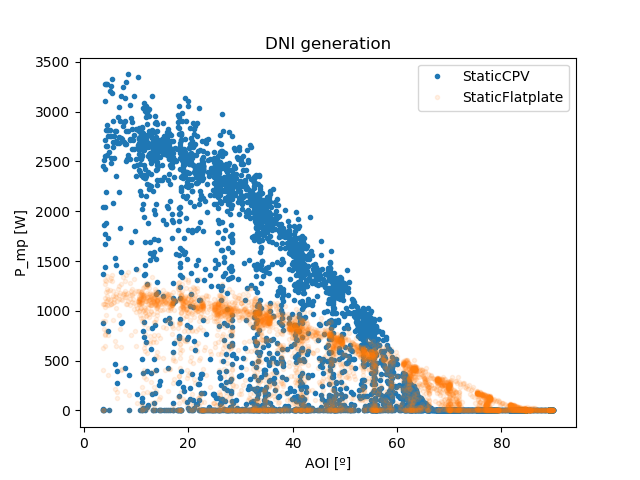

Text(0.5, 0, 'AOI [º]')

In [12]:
plt.plot(aoi[aoi<90], cpv_power_p_mp[aoi<90], '.', label='StaticCPV')
plt.plot(aoi[aoi<90], pv_dni_power['p_mp'][aoi<90], '.', alpha=0.1, label='StaticFlatplate')
plt.legend()
plt.title('DNI generation')
plt.ylabel('P_mp [W]')
plt.xlabel('AOI [º]')